In [9]:
import as_seg.scripts.default_path as paths
import as_seg.scripts.overall_scripts as scr
import as_seg.data_manipulation as dm

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl
import itertools
import matplotlib.pyplot as plt


In [2]:
bands_numbers = [None, 3, 7, 15]
bands_numbers_labels = ["Full kernel", "3-band kernel", "7-band kernel", "15-band kernel"]
bands_numbers_name_persisted_data = ["full", "3b", "7b", "15b"]

autosimilarity_types = ["Cosine", "Covariance", "RBF"]
penalty_function = "modulo8"
feature = "log_mel_grill"

hop_length = 32
hop_length_seconds = hop_length/44100
subdivision = 96

lambda_range = np.arange(0.1, 2.1, 0.1)

file_test_dataset = open(f"{os.getcwd()}/test_set_salami_gs.txt")

test_dataset = [] # Indexes of the song in the test dataset
for part in file_test_dataset.readlines():
    line_broken = part.split("\n")
    test_dataset.append(int(line_broken[0]))

In [7]:
def load_estimated_segments(key, idx_bands_number, autosimilarity_type):
    return np.load(f"../data/SALAMI/boundary_estimation_WASPAA/salami_{key}_{bands_numbers_name_persisted_data[idx_bands_number]}kernel_{autosimilarity_type.lower()}similarity.npy", allow_pickle = True)
    
def compute_experiments_with_precomputed_estimations():
    salami = mirdata.initialize('salami', data_home = paths.path_entire_salami)
    len_salami = len(salami.track_ids)
    
    results_salami = -math.inf * np.ones((len_salami, 4, 3, 2, 3)) # Songs, kernels, autosimilarities, tol, metrics
    
    all_tracks = salami.load_tracks()    
    song_idx = 0
        
    for key, track in all_tracks.items():
        if int(key) in test_dataset:
            try:
                ref_tab = []
                try:
                    references_segments = salami.load_sections(track.sections_annotator1_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass

                try:
                    references_segments = salami.load_sections(track.sections_annotator2_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass
                
                for idx_bn, bands_number in enumerate(bands_numbers):
                    for idx_as, as_type in enumerate(autosimilarity_types):    
                        segments_in_time = load_estimated_segments(key, idx_bn, as_type)

                        prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 0.5)
                        prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 3)
                        this_score = [[round(prec05,4),round(rap05,4),round(f_mes05,4)], [round(prec3,4),round(rap3,4),round(f_mes3,4)]]

                        if len(ref_tab) > 1:
                            nd_prec05, nd_rap05, nd_f_mes05 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 0.5)
                            nd_prec3, nd_rap3, nd_f_mes3 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 3)
                            if nd_f_mes05 + nd_f_mes3 > f_mes05 + f_mes3:
                                this_score = [[round(nd_prec05,4),round(nd_rap05,4),round(nd_f_mes05,4)], [round(nd_prec3,4),round(nd_rap3,4),round(nd_f_mes3,4)]]
                        results_salami[song_idx, idx_bn, idx_as] = np.array(this_score)
                song_idx += 1
                
            except FileNotFoundError:
                print(f"Song {key} is missing in the data.")

    avg_results_salami = np.mean(results_salami[:song_idx], axis = 0)
    
    dataframe = pd.DataFrame(avg_results_salami.reshape(12, 6), columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = list(itertools.product(bands_numbers_labels,autosimilarity_types)))
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))
    
    return avg_results_salami
avg_results_salami = compute_experiments_with_precomputed_estimations()

Song 70 is missing in the data.
Song 922 is missing in the data.


,P0.5,R0.5,F0.5,P3,R3,F3
"('Full kernel', 'Cosine')",0.470356,0.333378,0.380679,0.650558,0.460331,0.526010
"('Full kernel', 'Covariance')",0.381236,0.538193,0.433349,0.547488,0.778032,0.623811
"('Full kernel', 'RBF')",0.456924,0.460829,0.445349,0.635842,0.647052,0.622437
"('3-band kernel', 'Cosine')",0.214907,0.516243,0.292548,0.346876,0.845143,0.474946
"('3-band kernel', 'Covariance')",0.270589,0.563032,0.353250,0.403773,0.843209,0.527824
"('3-band kernel', 'RBF')",0.242601,0.589751,0.332324,0.362218,0.889803,0.497870
"('7-band kernel', 'Cosine')",0.295404,0.425627,0.337251,0.460640,0.664610,0.526431
"('7-band kernel', 'Covariance')",0.336502,0.572014,0.411415,0.483040,0.827240,0.592224
"('7-band kernel', 'RBF')",0.357324,0.555199,0.422079,0.512428,0.804206,0.607506
"('15-band kernel', 'Cosine')",0.377435,0.364684,0.360188,0.543348,0.522608,0.517368


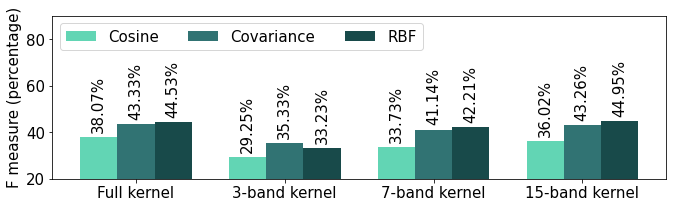

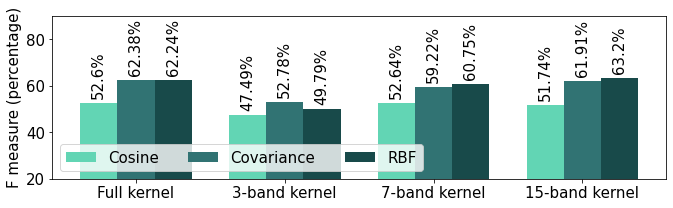

In [11]:
def plot_kernels_as(results_diff_as, kernels_or_features, autosimilarities, tol, title = None):
    # Order results_diff_as: kernels ou features, as, tol
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 15})
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    colors = ["#62d5b4", "#317373", "#184a4a"]#['skyblue', 'steelblue', 'darkorange', 'brown']
    
    fig, ax = plt.subplots(1, 1, figsize=(11,3))
    ax.set_ylim( 20,90)
    tab = []
    current_start = 0
    for i in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels_or_features))]
        tab.append(ax.bar(indexes, results_diff_as[:,i,tol], color=colors[i], width=width, align='edge'))
        for idx_x, x in enumerate(indexes):
            height = results_diff_as[idx_x, i, tol] 
            plt.text(x +width/2,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2 + j*gap for j in range(len(kernels_or_features))])
    ax.set_xticklabels(kernels_or_features)
    if tol == 1:
        ax.legend(labels=subaxis, loc='lower left', ncol = 3)

    else:
        ax.legend(labels=subaxis, loc='upper left', ncol = 3)

    ax.set_ylabel("F measure (percentage)")

    fig.savefig(f"results_barcomp_salami_{tol}.pdf", bbox_inches = "tight")#, format='png')
    if title != None:
        plt.title(title)
    plt.show()
    
plot_kernels_as(np.round(100 * avg_results_salami[:,:,:,2], decimals = 2), bands_numbers_labels, autosimilarity_types, 0, title = None)#f"F0.5 with the full kernel on SALAMI")
plot_kernels_as(np.round(100 * avg_results_salami[:,:,:,2], decimals = 2), bands_numbers_labels, autosimilarity_types, 1, title = None)#f"F3 with the full kernel on SALAMI")